In [21]:
import warnings
warnings.filterwarnings("ignore")
from run import main
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.lines import Line2D

In [22]:
# set up dataframe for collecting event data
"""
    start_time: the start time of the simulation (can only be used when you have saved state at that given timestamp)
    finish_time: the total simulation time
    mtd_type: 'shuffle_diversity', 'shuffle', diversity
    checkpoints: a list of simulation timestamp for state saving e.g. [1000, 5000, 7000]
"""
SIM_TIME = 1000
mtd_type = 'shuffle_diversity'
time_network, adversary = main(finish_time=SIM_TIME, mtd_type=mtd_type)

Adversary: Start SCAN_HOST at 0.0s.
MTD: IPShuffle triggered 0.0s
MTD: IPShuffle deployed in the network at 0.0s.
Adversary: Processed SCAN_HOST at 10.0s.
Adversary: Start ENUM_HOST at 10.0s.
Adversary: Processed ENUM_HOST at 25.0s.
Adversary: Start SCAN_PORT at 25.0s.
MTD: IPShuffle triggered 30.8s
MTD: IPShuffle suspended at 30.8s due to resource occupation
Adversary: Processed SCAN_PORT at 45.0s.
Adversary: Start EXPLOIT_VULN at 45.0s.
MTD: IPShuffle finished in 50.4s at 50.4s.
MTD: Interrupted EXPLOIT_VULN at 50.4s!
Adversary: Restarting with SCAN_HOST at 52.4s!
Adversary: Start SCAN_HOST at 52.4s.
MTD: IPShuffle triggered 61.8s
MTD: IPShuffle deployed in the network at 61.8s.
Adversary: Processed SCAN_HOST at 62.4s.
Adversary: Start ENUM_HOST at 62.4s.
Adversary: Processed ENUM_HOST at 77.4s.
Adversary: Start SCAN_PORT at 77.4s.
MTD: osdiversity triggered 92.2s
MTD: osdiversity deployed in the network at 92.2s.
Adversary: Processed SCAN_PORT at 97.4s.
Adversary: Start EXPLOIT_VULN

In [23]:
mtd_operation_record = pd.DataFrame(time_network.get_mtd_stats().get_record())
attack_operation_record = pd.DataFrame(adversary.get_attack_stats().get_record())
current_directory = os.getcwd()
if not os.path.exists(current_directory+'\\data_analysis'):
    os.makedirs(current_directory+'\\data_analysis')

attack_operation_record.to_csv('data_analysis/attack_operation_record_'+str(SIM_TIME)+'_'+mtd_type+'.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record_'+str(SIM_TIME)+'_'+mtd_type+'.csv', index=False)

In [24]:
# print(time_network.get_mtd_stats().dict())
mtd_operation_record.head()

,name,start_time,finish_time,duration,executed_at
0,IPShuffle,0.000000,50.360911,50.360911,network
1,IPShuffle,61.827047,111.978712,50.151664,network
2,osdiversity,92.240900,122.508460,30.267561,application
3,HostTopologyShuffle,123.221201,184.172693,60.951493,network
4,IPShuffle,216.144170,266.556902,50.412732,network


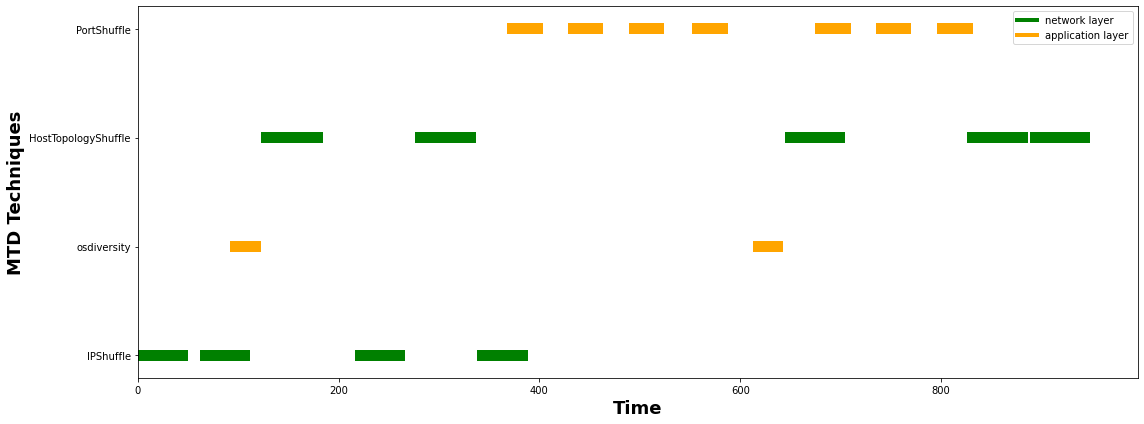

In [25]:
mtd_operation_record['color'] = np.where(mtd_operation_record['executed_at']=='network', 'green', 'orange')
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(mtd_operation_record['name'], mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.1, color=mtd_operation_record['color'])


custom_lines_mtd = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4)]
ax.legend(custom_lines_mtd, ['network layer', 'application layer'], loc='upper right')
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.savefig('data_analysis/mtd_record.png')
plt.show()

In [26]:
attack_operation_record.head()

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
0,SCAN_HOST,0.000000,10.000000,10.000000,-1,0,0,0,None,[],None,None
1,ENUM_HOST,10.000000,25.000000,15.000000,-1,0,0,0,None,[],None,None
2,SCAN_PORT,25.000000,45.000000,20.000000,0,1,0,0,None,[],None,None
3,EXPLOIT_VULN,45.000000,50.360911,5.360911,0,1,0,0,None,[],network,IPShuffle
4,SCAN_HOST,52.360911,62.360911,10.000000,-1,0,0,0,None,[],None,None


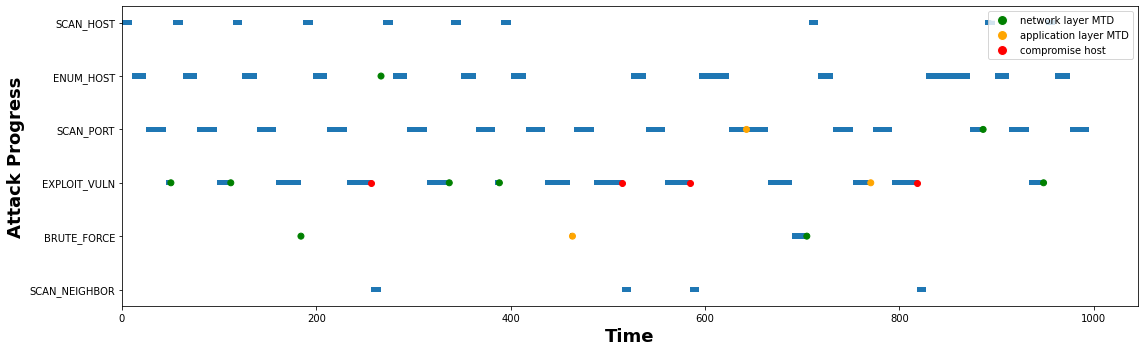

In [27]:
fig2, ax2 = plt.subplots(1, figsize=(16, 5))
ax2.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1, zorder=1)


interrupted_record = attack_operation_record[attack_operation_record['interrupted_in']!='None']
interrupted_record['color'] = np.where(interrupted_record['interrupted_in']=='network', 'green', 'orange')
ax2.scatter(interrupted_record['finish_time'], interrupted_record['name'], color=interrupted_record['color'], zorder=2)


compromise_record = attack_operation_record[attack_operation_record['compromise_host'] != 'None']
ax2.scatter(compromise_record['finish_time'], compromise_record['name'], color='red', zorder=2)


custom_lines_attack = [Line2D([0], [0], marker='o',color='w', markerfacecolor='green', markersize=10),
                Line2D([0], [0], marker='o',color='w', markerfacecolor='orange', markersize=10),
                Line2D([0], [0], marker='o',color='w', markerfacecolor='red', markersize=10),]

ax2.legend(custom_lines_attack, ['network layer MTD', 'application layer MTD', 'compromise host'], loc='upper right')

plt.gca().invert_yaxis()
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig2.tight_layout()
plt.savefig('data_analysis/attack_record.png')
plt.show()

In [28]:
attack_operation_record[(attack_operation_record['name'] == 'SCAN_PORT') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by


In [29]:
attack_operation_record[(attack_operation_record['name'] == 'EXPLOIT_VULN') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
16,EXPLOIT_VULN,231.172693,256.439801,25.267107,0,4,5,0,0,"[Cherrita, Moyna, Wallis, Filippa, Germana]",None,None
33,EXPLOIT_VULN,485.536267,514.021804,28.485537,52,3,52,1,52,"[Horatia, Gwenora, Jenilee, Cristy]",None,None
37,EXPLOIT_VULN,559.021804,584.087074,25.065269,53,1,85,2,53,"[Lilah, Katrina, Georgeanne, Julita, Adria]",None,None
50,EXPLOIT_VULN,792.456606,817.538899,25.082293,52,5,111,3,52,"[Berenice, Libbey, Reggi, Zorana, Maribeth]",None,None


In [30]:
attack_operation_record[(attack_operation_record['name'] == 'BRUTE_FORCE') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
